# RL: The true AI

Reinforcment learning is the branch of machine learning that tries to find the optimal policy the agent should follow in an environemnt.
The following picture is a summary of a given reinforecment learning environemnt and the actions that an agent take.

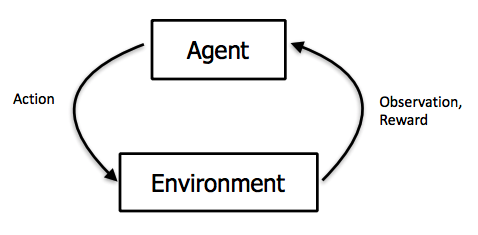

In [1]:
import math
from numpy import array
import numpy as np
from math import inf
import gym
from IPython.display import clear_output
from time import sleep
import random
import pandas as pd
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

/home/ahmed/anaconda3/lib/python3.9/site-packages/gym/envs/registration.py:423: UserWarning: WARN: Custom namespace `ALE` is being overridden by namespace `ALE`. If you are developing a plugin you shouldn't specify a namespace in `register` calls. The namespace is specified through the entry point package metadata.
  logger.warn(


let us generalize the Making of environment.  The function accepts any valid environment's name.

In [2]:
def MakeEnv(env_name:str):
    return gym.make(env_name).env
env = MakeEnv('Taxi-v3')

## Non-RL solution

This solution uses a naive, non-RL-based approach.

In [3]:
frames = []
def NaiveSolution(env, frames, penalties=0, reward=0, epochs=0):
    done = False
    while not done:
      # automatically selects one random action 
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )

        epochs += 1
    return epochs, penalties
epochs, penalties = NaiveSolution(env, frames)

The following function visualizes the process of the non-RL-based solution.

In [4]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        #print(frame['frame'].getvalue())
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)


# uncomment the below command to visualize the process tha egent goes through.        
#print_frames(frames)

## Decay of hyper parameters

we have three hyper parameters in the Q-learning algorithm:
1. $\alpha$: learning rate or how much we update the . 
2. $\gamma$: how much the agent is greedy for immediate higher q_value.
3. $\epsilon$: exploration vs exploitation probabilities.

The following [link](https://stackoverflow.com/questions/53198503/epsilon-and-learning-rate-decay-in-epsilon-greedy-q-learning) proposes wha is called **decayed_epsilon_greedy**. which follows the following equation:
$$r = \max (\frac{N - n_s}{N}, 0)$$ 
$$\epsilon = (p_i - p_e) * r + p_e$$

But how to update $\alpha$ and $\gamma$? this is not a single approach task but a set of tricks that can be used according to the situation. This [link](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1) clarifies that the update of $\alpha$ could be as simple as dropping it to half.

since there is not a universal policy on how to do the decay of $\gamma$, I prefer not to touch it.

The thing is, there is no optimal policy on how to update those hyper parameters since we have different approaches depending on the environment and the situation. for example, there is a momentum-based approach to update the learning rate and there is a time-based approach.


In [5]:
def decayed_epsilon_greedy(epsilon, N, n_steps=10, p_init=0.6, p_end=0.1):
    '''
        uses the above two equations to update the epsilon.
    '''
    r = max(0, ((N - n_steps) / N))
    return (p_init - p_end) * r + p_end
    
def update_alpha(alpha, alpha_0=0.1, drop=0.6, N=10000, epochs_drop=10000):
    '''
        the simplest approach is to drop alpha to half or close to half.
    '''
    return alpha /1.5


### Q learning Algorithm

The Q-learning algorithm is very simple to implement. It maintains a table, called *Q table* that shows the state aginst all the rewards of every possible move you take from this step. During iterations, we are going to apply the decay schedule defined above.

In [6]:
all_epsilons = []
all_alphas = []
all_gammas = []

def Q_learning(env, hyper_params, fixed_params=False):
    global frames
    frames = []
    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    
    # Hyperparameters
    alpha = hyper_params['alpha']
    gamma = hyper_params['gamma']
    epsilon = hyper_params['epsilon']

    # For plotting metrics
    all_epochs = []
    all_penalties = []
    
    
    all_epsilons.append(epsilon)
    all_alphas.append(alpha)
    all_gammas.append(gamma)
    N = 100001
    for i in range(1, N):
        state = env.reset()
        
        all_epsilons.append(epsilon)
        all_alphas.append(alpha)
        all_gammas.append(gamma)
        
        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values

            next_state, reward, done, info = env.step(action) 

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value
            
            frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
            
            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1
        if i% 20000 == 0: 
            if not fixed_params:
                epsilon = decayed_epsilon_greedy(epsilon, N, i, 0.1, 0.001)
                alpha = update_alpha(alpha)
 

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

    print("Training finished.\n")
    
    return q_table

hyper_params = {'alpha' : 0.1, 'gamma' : 0.6, 'epsilon' : 0.1}
q_table = Q_learning(env, hyper_params)

Episode: 100000
Training finished.



The following is a visualization of the process of training the agent. 

**Warning: It will take time, a long time**

In [7]:
# uncomment to visualize.
#print_frames(frames)

The resulting Q_table is as follows:

In [8]:
cols = ['South(0)', 'North(1)', 'East(2)', 'West(3)', 'Pickup(4)', 'Dropoff(5)']
index = ['state ' + str(i) for i in range(1, 501)]
pd.DataFrame(q_table, columns=cols, index=index)

,South(0),North(1),East(2),West(3),Pickup(4),Dropoff(5)
state 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
state 2,-2.417803,-2.363885,-2.418147,-2.363831,-2.273252,-11.350228
state 3,-1.869571,-1.450733,-1.869926,-1.450827,-0.750400,-10.434644
state 4,-2.362985,-2.273151,-2.363114,-2.273206,-2.122086,-11.250705
state 5,-2.496190,-2.496470,-2.496190,-2.496544,-8.756236,-10.167336
...,...,...,...,...,...,...
state 496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
state 497,-2.126881,-2.114675,-2.116586,-2.114739,-3.211963,-6.203870
state 498,-1.149138,0.402312,-1.198993,-1.210810,-3.490574,-2.832574
state 499,-2.120781,-2.117061,-2.120237,-2.116967,-4.846041,-4.907152


### Debugging our hyperparamters decay schedule.

To make sure that the decay is really working, we can visualize how they are changing over the training iterations. If they are approaching zero as the number of iterations get colse to end, then it really works. The following function is doing just this.

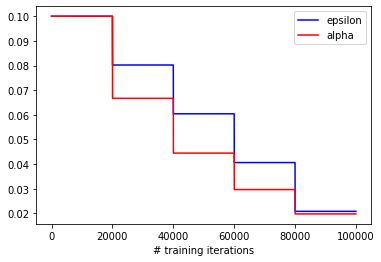

In [9]:
def debug(all_epsilons, all_alphas, all_gamas = []):
    plt.plot(np.arange(0, 100001), all_epsilons, "-b",  label="epsilon")
    plt.plot(np.arange(0, 100001), all_alphas, "-r", label= "alpha")
    #plt.plot(np.arange(0, 100001), all_gammas, "-g", label= "gamma")
    plt.legend(loc="upper right")
    plt.xlabel('# training iterations')

debug(all_epsilons, all_alphas, all_gammas)

We can clearly see that the curve gets colser to zero as it approaches N (the total number of iterations).
$$\lim_{i \to N} \epsilon = 0$$ and also $$\lim_{i \to N} \alpha = 0$$

### Evaluating the Agent:
we evluate the agent given the resulting q table. we use the first 100 episodes to evaluate.

In [10]:
def evalAgent(env, q_table):
    # Evaluation
    """
    Evaluate agent's performance after Q-learning based on the given q_table
    
    """
    
    total_epochs, total_penalties = 0, 0
    episodes = 100
    R = 0
    for _ in range(episodes):
        
        state = env.reset()
        epochs, penalties, reward = 0, 0, 0

        done = False

        while not done:
            action = np.argmax(q_table[state])
            state, reward, done, info = env.step(action)

            if reward == -10:
                penalties += 1

            epochs += 1
            R += reward
        total_penalties += penalties
        total_epochs += epochs
    print(f"Results after {episodes} episodes:")
    print(f"Average timesteps per episode: {total_epochs / episodes}")
    print(f"Average penalties per episode: {total_penalties / episodes}")
    print(f"Average rewards per episode {reward/episodes}")
    print(f"Total rewards is {R}")
    return total_epochs/episodes, total_penalties, R
    
evalAgent(env, q_table)

Results after 100 episodes:
Average timesteps per episode: 13.25
Average penalties per episode: 0.0
Average rewards per episode 0.2
Total rewards is 775


(13.25, 0, 775)

### GridSearch: Automating Hyperparmater optimization

GridSearch attempts to find the best combination of hyperparameters from a given set of combinations. It goes through all the combination that you specify and find the best Q table resulted from learning. 

Here, I made 4 combinations only to make sure that the grid_search will not take a lot of time.

In [11]:
models_info = []
def grid_search(params:list) -> None:
    
    global env
    global models_info
    for param in params:
        q_table = Q_learning(env, param, fixed_params=True)
        total_epochs, penalties, R = evalAgent(env, q_table)
        models_info.append([total_epochs, penalties, R, param])

comb_1 = {'alpha':0.1, 'gamma':0.6 , 'epsilon':0.1}
comb_2 = {'alpha':0.1, 'gamma':0.6 , 'epsilon':0.01}
comb_3 = {'alpha':0.1, 'gamma':0.5 , 'epsilon':0.1}
comb_4 = {'alpha':0.3, 'gamma':0.5 , 'epsilon':0.01}

hyper_params = [comb_1, comb_2, comb_3, comb_4]

grid_search(hyper_params)

Episode: 100000
Training finished.

Results after 100 episodes:
Average timesteps per episode: 12.93
Average penalties per episode: 0.0
Average rewards per episode 0.2
Total rewards is 807


Now, we have two options:
1. choosing the model with the highest reward values.
2. choosing the model with the lowest penalities.

I choose the first method.

In [12]:
max_reward = models_info[0][2]
best_params = models_info[0][3]
for model in models_info:
    if model[2] > max_reward:
        max_reward = model[2]
        best_params = model[3]
best_params

{'alpha': 0.1, 'gamma': 0.6, 'epsilon': 0.1}